In [2]:
# %%capture
# !pip install pandas numpy matplotlib scikit-image tqdm gdown opencv-python plotly pillow scikit-learn
# !pip install nbformat --upgrade
# !pip install --upgrade jupyter ipywidgets
# !pip install pyimagej scyjava


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import skimage.io as skio
from skimage.color import rgb2gray, rgba2rgb, hsv2rgb
from tqdm.notebook import tqdm as tqdm
from skimage.transform import resize
from copy import deepcopy

import shutil
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import os
import gdown
import cv2

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image

import json
from matplotlib.patches import Rectangle


import os
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from fastcluster import linkage_vector, linkage

import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.colors as mcolors
import os, sys

import scipy.cluster.hierarchy as sch
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl


In [4]:
def glob_filepath(folder, ext, subfolder=False):
    """
    Get all the filepaths of a folder with a given extension without case sensitivity
    Args: folder -> the folder to search
          ext -> the extension of the files to search for
          subfolder -> whether to include subfolders in the search
    Return: list of filepaths
    """
    filepath = []

    if folder[-1] != '/' and folder != '':
        folder += '/'

    if not isinstance(ext, list):
        ext = [ext]

    if subfolder:
        folder = os.path.join(folder, '**')

    for item in ext:
        # Using glob with case-insensitive patterns
        filepath += glob(os.path.join(folder, '*.' + item), recursive=subfolder)
        filepath += glob(os.path.join(folder, '*.' + item.upper()), recursive=subfolder)
        filepath += glob(os.path.join(folder, '*.' + item.lower()), recursive=subfolder)
    
    return sorted(list(set(filepath)))


In [134]:
filepaths = glob_filepath('../data/data_v1/labelme/**/', ['csv', 'xlsx'], subfolder=True)
print(filepaths)

['../data/data_v1/labelme/pistachio24_BACK(1) (1)/pistachio_statistics.csv', '../data/data_v1/labelme/pistachio24_FRONT(3)/pistachio_statistics.csv']


In [135]:
BACK_df = pd.read_csv(filepaths[0])
BACK_df['dataset'] = 'BACK'
FRONT_df = pd.read_csv(filepaths[1])
FRONT_df['dataset'] = 'FRONT'
pistachio_df = pd.concat([BACK_df, FRONT_df])
display(pistachio_df.head())
display(pistachio_df['dataset'].value_counts())

display(pistachio_df[pistachio_df.duplicated(subset='Pistachio_ID', keep=0)].sort_values('Pistachio_ID'))

,Pistachio_ID,Longest_Distance,Same_Y_Axis_Largest_Vert_Distance,Same_X_Axis_Largest_Horiz_Distance,Vertical_Distances_5%,Vertical_Distances_25%,Vertical_Distances_50%,Vertical_Distances_75%,Vertical_Distances_95%,Filename,dataset
0,21,136.132289,4,49,0,1,3,3,3,annotated_pistachio_21.png,BACK
1,23,165.680415,14,66,2,6,10,14,14,annotated_pistachio_23.png,BACK
2,24,157.276826,9,48,1,3,6,8,8,annotated_pistachio_24.png,BACK
3,25,148.973152,17,110,6,12,15,16,14,annotated_pistachio_25.png,BACK
4,26,151.647618,16,77,2,6,11,15,16,annotated_pistachio_26.png,BACK


FRONT    80
BACK     78
Name: dataset, dtype: int64

,Pistachio_ID,Longest_Distance,Same_Y_Axis_Largest_Vert_Distance,Same_X_Axis_Largest_Horiz_Distance,Vertical_Distances_5%,Vertical_Distances_25%,Vertical_Distances_50%,Vertical_Distances_75%,Vertical_Distances_95%,Filename,dataset
0,21,136.132289,4,49,0,1,3,3,3,annotated_pistachio_21.png,BACK
0,21,126.099167,3,48,1,3,3,3,3,annotated_pistachio_21.png,FRONT
2,23,154.935470,17,96,1,6,12,16,14,annotated_pistachio_23.png,FRONT
1,23,165.680415,14,66,2,6,10,14,14,annotated_pistachio_23.png,BACK
2,24,157.276826,9,48,1,3,6,8,8,annotated_pistachio_24.png,BACK
...,...,...,...,...,...,...,...,...,...,...,...
75,98,154.207652,16,64,1,5,10,15,13,annotated_pistachio_98.png,BACK
78,99,171.828403,35,115,9,20,30,35,35,annotated_pistachio_99.png,FRONT
76,99,169.425500,25,96,2,8,16,23,18,annotated_pistachio_99.png,BACK
77,100,153.759553,25,69,3,10,17,23,25,annotated_pistachio_100.png,BACK


In [145]:
pistachio_df['nut_length_div_pistachio_length'] = pistachio_df['Same_X_Axis_Largest_Horiz_Distance'] / pistachio_df['Longest_Distance']
pistachio_df['largest_nut_width'] = pistachio_df['Same_Y_Axis_Largest_Vert_Distance']
pistachio_df['nut_with_5%_div_largest_nut_width'] = pistachio_df['Vertical_Distances_5%'] / pistachio_df['largest_nut_width']
pistachio_df['nut_with_25%_div_largest_nut_width'] = pistachio_df['Vertical_Distances_25%'] / pistachio_df['largest_nut_width']
pistachio_df['nut_with_50%_div_largest_nut_width'] = pistachio_df['Vertical_Distances_50%'] / pistachio_df['largest_nut_width']
pistachio_df['nut_with_75%_div_largest_nut_width'] = pistachio_df['Vertical_Distances_75%'] / pistachio_df['largest_nut_width']

In [161]:
data_df = pistachio_df[['Pistachio_ID', 'dataset', 'nut_length_div_pistachio_length', 'nut_with_5%_div_largest_nut_width', 'nut_with_25%_div_largest_nut_width', 'nut_with_50%_div_largest_nut_width', 'nut_with_75%_div_largest_nut_width', 'largest_nut_width']]
data_df = data_df.round(3)
display(data_df.head())

,Pistachio_ID,dataset,nut_length_div_pistachio_length,nut_with_5%_div_largest_nut_width,nut_with_25%_div_largest_nut_width,nut_with_50%_div_largest_nut_width,nut_with_75%_div_largest_nut_width,largest_nut_width
0,21,BACK,0.360,0.000,0.250,0.750,0.750,4
1,23,BACK,0.398,0.143,0.429,0.714,1.000,14
2,24,BACK,0.305,0.111,0.333,0.667,0.889,9
3,25,BACK,0.738,0.353,0.706,0.882,0.941,17
4,26,BACK,0.508,0.125,0.375,0.688,0.938,16


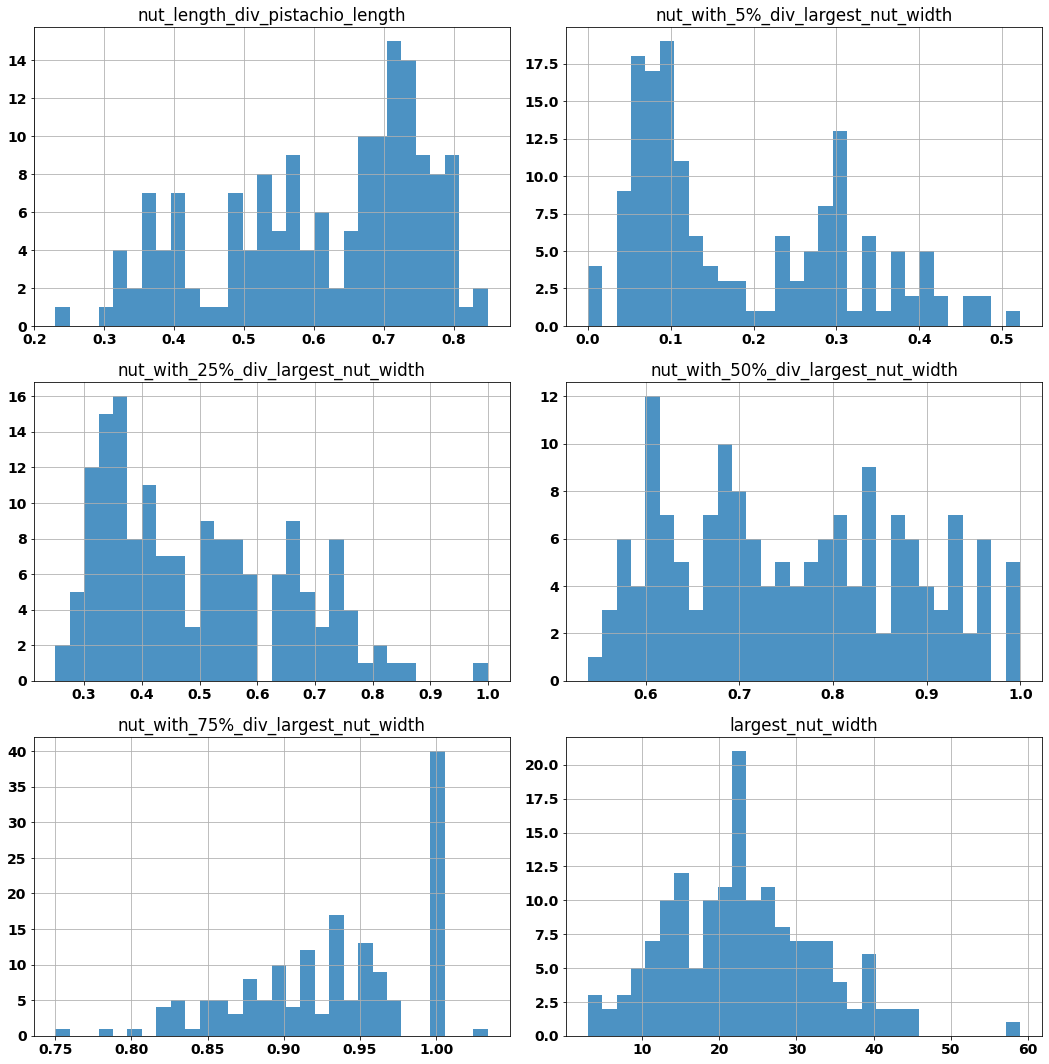

In [163]:
data_df.drop(['Pistachio_ID', 'dataset'], axis=1).hist(figsize=(15, 15), bins=30, alpha=0.8)

plt.tight_layout()
plt.show()


In [164]:
filepaths = glob_filepath('../data/data_v1/labelme/**/', ['json'], subfolder=False)
filepaths

['../data/data_v1/labelme/pistachio24_BACK(1) (1)/labels.json',
 '../data/data_v1/labelme/pistachio24_FRONT(3)/labels.json']

In [165]:
def read_labels(json_file):
    json_data = json.load(open(json_file))
    json_data = np.array(json_data['labels']).transpose()
    json_data = pd.DataFrame(json_data).T.rename(columns={0: 'Pistachio_ID', 1: 'Type', 2: 'Label'})
    json_data['Pistachio_ID'] = json_data['Pistachio_ID'].astype('Int64')
    return json_data


In [166]:
BACK_label = read_labels(filepaths[0])
BACK_label['dataset'] = 'BACK'
FRONT_label = read_labels(filepaths[1])
FRONT_label['dataset'] = 'FRONT'


In [167]:
pistachio_label = pd.concat([BACK_label, FRONT_label], axis=0).reset_index(drop=True)
data_df = data_df.merge(pistachio_label, on=['Pistachio_ID', 'dataset'], how='left')
data_df

,Pistachio_ID,dataset,nut_length_div_pistachio_length,nut_with_5%_div_largest_nut_width,nut_with_25%_div_largest_nut_width,nut_with_50%_div_largest_nut_width,nut_with_75%_div_largest_nut_width,largest_nut_width,Type,Label
0,21,BACK,0.360,0.000,0.250,0.750,0.750,4,back,no
1,23,BACK,0.398,0.143,0.429,0.714,1.000,14,back,low
2,24,BACK,0.305,0.111,0.333,0.667,0.889,9,back,low
3,25,BACK,0.738,0.353,0.706,0.882,0.941,17,back,med
4,26,BACK,0.508,0.125,0.375,0.688,0.938,16,belly,low
...,...,...,...,...,...,...,...,...,...,...
153,96,FRONT,0.374,0.067,0.400,0.667,1.000,15,belly,low
154,97,FRONT,0.694,0.522,0.870,1.000,0.957,23,belly,high
155,98,FRONT,0.712,0.391,0.739,0.957,1.000,23,belly,high
156,99,FRONT,0.669,0.257,0.571,0.857,1.000,35,belly,high


In [174]:


import scipy.cluster.hierarchy as sch
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl


def rgb2hex(rgb):
    """
    Convert RGB to hexadecimal
    """
    try:
        r, g, b = tuple(rgb)
        return "#{:02x}{:02x}{:02x}".format(int(r),int(g),int(b))
    except:
        print(f'failed rgb {rgb}')


import pandas as pd
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

import matplotlib.colors as mcolors

def representative_rgb(df, cols, method="mean", weights=None, qtl=None):
    df_ = df.copy()
    df_ = df_[cols]
    if method == "mean":
        return tuple(df_.mean().astype(int))
    
    elif method == "quantile":
        if qtl is None:
            raise ValueError("A quantile value is required for the quantile method.\n\nExample: Pass qtl=0.5 for the median.")
        return tuple(df_.quantile(qtl))
    
    elif method == "mode":
        mode_val = df_.mode().iloc[0]
        return tuple(mode_val.astype(int))
    
    elif method == "dominant":
        kmeans = KMeans(n_clusters=1).fit(df_)
        dominant_color = kmeans.cluster_centers_[0]
        return tuple(dominant_color.astype(int))
    
    elif method == "weighted":
        if weights is None:
            raise ValueError("Weights are required for the weighted average method.")
        weighted_avg = (df_.T * weights).T.sum() / sum(weights)
        return tuple(weighted_avg.astype(int))
    
    elif method == "pca":
        if (df_.var() == 0).any():
            print("Warning: One or more columns have zero variance. PCA will not work with these columns.\n\nReturning the mean instead.")
            return tuple(df_.mean().astype(int))
        pca = PCA(n_components=1)
        transformed_data = pca.fit_transform(df_)
        representative_score = np.mean(transformed_data, axis=0)
        pca_color = pca.inverse_transform(representative_score)
        return tuple(pca_color.astype(int))

    
    elif method == "harmonic":
        harmonic_mean = df_.apply(stats.hmean, axis=0) if not df_.isin([0]).any().any() else df_.mean()
        return tuple(harmonic_mean.astype(int))
    
    else:
        raise ValueError(f"Unknown method: {method}")


def generate_distinct_colors(n):
    """ Generate n visually distinct colors. """
    colors = [mcolors.hsv_to_rgb((i/n, 1, 1)) for i in range(n)]
    colors = [mcolors.to_hex(color) for color in colors]
    return colors

def ColorsSequence3DScatterPerCluster(df, cols, method, weights=None, qtl=None, color_dict = None):
    df_ = df.copy()
    clusters = df_['Clusters'].drop_duplicates()
    if method == 'random':
        clustered_colors_list = generate_distinct_colors(clusters.shape[0])
        df_['ClusterColor'] = df_['Clusters'].map(dict(zip(clusters, clustered_colors_list)))
    elif method == 'predetermined' and color_dict is not None:
        clustered_colors_list = generate_distinct_colors(clusters.shape[0])
        df_['ClusterColor'] = df_['Clusters'].map(color_dict)
    elif len(cols) == 3 and method == 'rgb':
        for ii in range(clusters.shape[0]):
            colors = df_.query('Clusters == {}'.format(ii))
            color_rep = representative_rgb(colors, cols, method=method, weights=weights, qtl=qtl)[:3]
            df_.loc[df_['Clusters'] == ii, 'ClusterColor'] = rgb2hex(color_rep)
    else:
        raise(ValueError, 'The method for assigning colors must either be random, predetermined with color dict provided\n or rgb with rgb columns provided')

    return df_


def mapClusters(df, link, n_clusters = 2, height = None):
    df_ = df.copy()
    if height == None:
        clusters = sch.cut_tree(Z=link, n_clusters=n_clusters)
    else:
        clusters = sch.cut_tree(Z=link, height = height)
    df_['Clusters'] = clusters
    return df_



In [216]:
def make_plot_dendogram(df, response_color_cols,  cluster_col, cluster_color_col,
                         link, leaf_label_col, save, save_dir, response_col=None,
                           remove_ticks=True, show_plot=False):
    df_ = df.copy()
    clustered_leaf_labels = df_[cluster_color_col].values
    if isinstance(response_color_cols, str):
        response_color_cols = [response_color_cols]

    if len(response_color_cols) == 3:
        unclustered_leaf_labels = list(map(rgb2hex, df_[response_color_cols].values))
    elif len(response_color_cols) == 1:
        unclustered_leaf_labels = df_[response_color_cols].values.flatten()
    else:
        print(f'\nInvalid response_color_cols: {response_color_cols}. This should either contain 3 columns for rgb colors or 1 column for categorical hex colors\n')
        print(f'Exiting...')
        sys.exit(1)
        
    plt.clf()
    fig = plt.figure(figsize=(25, 10))
    print(f'=========================================================')
    print(f'Head of data')
    print(df_.head(3))
    print(f'=========================================================')
    print(f'response colors columns: {response_color_cols}')
    print(f'cluster column: {cluster_col}')
    print(f'cluster color column: {cluster_color_col}')
    print(f'leaf_label_col: {leaf_label_col}')
    print(f'data shape: {df_.shape}')
    print(f'link shape: {link.shape}')
    print(f'data index: {df_.index}')
    print(f'clustered_leaf_labels: {clustered_leaf_labels[:10]}')
    print(f'unclustered_leaf_labels: {unclustered_leaf_labels[:10]}')
    print(f'=========================================================')

    plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "font.weight": "bold"})
    if leaf_label_col is None:
        dn = sch.dendrogram(link, color_threshold=0.5*link[-1,2] )
    else:
        leaf_label = df_[leaf_label_col].values
        dn = sch.dendrogram(link, labels=leaf_label, color_threshold=0.5*link[-1,2] )
    

    plt.title("Dendrogram")
    # plt.xlabel("Leaf Labels")
    plt.ylabel("Distance")
    

    print(f"dendogram leave order: {dn['leaves'][:50]}")
    print(f'=========================================================')

    ax = plt.gca()
    x_points = ax.get_xticks()
    y_points = np.zeros(len(x_points))
    xlbls = ax.get_xmajorticklabels()

    leaf_order = dn['leaves']
    
    color_idx = []
    clustered_colors_list = clustered_leaf_labels[leaf_order]
    unclustered_colors_list = unclustered_leaf_labels[leaf_order]
    
    for idx, lbl in enumerate(xlbls):
        lbl.set_fontsize(18)
        lbl.set_fontweight('bold')
        # color_idx.append(lbl.get_text())
        color_idx.append(idx)

    ax_bbox = ax.get_position()
    # cax1 = fig.add_axes([ax_bbox.x0, -0.14 + -0.065, ax_bbox.width, 0.05])
    cax1 = fig.add_axes([ax_bbox.x0, -0.165, ax_bbox.width, 0.05])
    
    # create custom colorbar
    cm1 = LinearSegmentedColormap.from_list('custom_colormap', clustered_colors_list, N=len(clustered_colors_list))
    sc1 = plt.scatter(x_points, y_points, c=color_idx, cmap=cm1)
    clustered_cb = plt.colorbar(sc1, cax=cax1,  orientation='horizontal')

    # set the size of nex axis [x0,y0,width,height]
    # cax2 = fig.add_axes([ax_bbox.x0, -0.01, ax_bbox.width, 0.05])
    cax2 = fig.add_axes([ax_bbox.x0, -0.14, ax_bbox.width, 0.05])
    cm2 = LinearSegmentedColormap.from_list('custom_colormap', unclustered_colors_list, N=len(unclustered_colors_list))
    sc2 = plt.scatter(x_points, y_points, c=color_idx, cmap=cm2)
    unclustered_cb = plt.colorbar(sc2, cax=cax2,  orientation='horizontal', pad = 0.3)

    df_cluster_unique = df_[[cluster_col, cluster_color_col]].drop_duplicates()
    cluster_colors = df_cluster_unique[cluster_color_col].values
    cluster_label = df_cluster_unique[cluster_col].values
    
    cax3 = fig.add_axes([ax_bbox.width+0.15, ax_bbox.y0, 0.05, ax_bbox.height-0.05])
    cmap = mpl.colors.ListedColormap(cluster_colors)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5, df_cluster_unique.shape[0]), cmap.N)
    sc3 = plt.scatter(cluster_label, np.zeros(len(cluster_label)), c = cluster_label, cmap=cmap, norm=norm)
    clustered_vert = plt.colorbar(sc3, cax=cax3,  orientation='vertical', spacing='proportional', ticks=range(len(cluster_label)))
    clustered_vert.ax.set_title('Cluster Id', loc='center', pad=10, fontsize=16, fontweight='bold')
    
    if len(response_color_cols) == 1:
        response_color_cols = response_color_cols[0]
        if response_col is None:
            response_col = response_color_cols.split(' ')[0]
        df_cluster_unique = df_[[response_color_cols, response_col]].drop_duplicates()
        cluster_colors = df_cluster_unique[response_color_cols].values
        cluster_label_ = df_cluster_unique[response_col].values
        print("========************================************================************========")
        print(f'cluster_label_: {cluster_label_}')
        display(df_cluster_unique)
        print("========************================************================************========")
        cluster_label = np.array([x for x in range(len(cluster_label_))])

        cax4 = fig.add_axes([ax_bbox.width+0.15, -0.01, 0.05, 0.05])
        cmap = mpl.colors.ListedColormap(cluster_colors)
        norm = mpl.colors.BoundaryNorm(np.arange(-0.5, df_cluster_unique.shape[0]), cmap.N)
        sc4 = plt.scatter(cluster_label, np.zeros(len(cluster_label)), c = cluster_label, cmap=cmap, norm=norm)
        unclustered_vert = plt.colorbar(sc4, cax=cax4,  orientation='vertical', ticks=range(len(cluster_label)))
        unclustered_vert.ax.set_title(response_col, loc='center', pad=10, fontsize=16, fontweight='bold')
        unclustered_vert.set_ticklabels(cluster_label_) 

    if remove_ticks:
        ax.set_xticklabels([])
    clustered_cb.ax.tick_params(size=0)
    unclustered_cb.ax.tick_params(size=0)
    clustered_cb.ax.set_xticklabels([])
    unclustered_cb.ax.set_xticklabels([])

    if save:
        if save_dir is None:
            file_name = f'dendogram.pdf'
        else:
            os.makedirs(save_dir, exist_ok=True)
            file_name = os.path.join(save_dir, f'dendogram.pdf')
        plt.savefig(file_name, format='pdf', bbox_inches='tight')
        print(f"Plot saved as {file_name}")
    if show_plot:
        plt.show()


In [236]:

def cluster_center(df, cols_to_cluster, n_cluster, leaf_label_col=None, response_col=None, 
                   response_color_cols=None, drop_duplicates=False, add_noise=False,
                   linkage_method='ward', linkage_metric='euclidean', remove_ticks=None,
                   weights=None, qtl=None, cluster_color_method='random', color_dict=None,
                    save=False, save_dir=None, plot_dendogram = True):
    df_ = df.copy()
    if add_noise:
        noise_scale = 1e-5  
        np.random.seed(0)  
        for col in cols_to_cluster:
            noise = np.random.uniform(-noise_scale, noise_scale, df.shape[0])
            df_[col] = df_[col].astype('float') + noise
            
    df_center_unique = df_[cols_to_cluster].drop_duplicates()
    print('Clustering on ...')
    print(df_center_unique.head(3)) 
    df_center_unique_ = df_center_unique.copy(deep=True)           
    link = linkage(df_center_unique_, method=linkage_method, metric=linkage_metric)
    df_center_unique = ColorsSequence3DScatterPerCluster(mapClusters(df_center_unique, link, n_clusters=n_cluster), cols_to_cluster,  
                                                         method=cluster_color_method, color_dict=color_dict, weights=weights, qtl=qtl)

    if drop_duplicates:
        df__ = pd.merge(df_, df_center_unique, how='right', on=cols_to_cluster).drop_duplicates(subset=cols_to_cluster)
        print("========================================================")
        print(f'Dropped {df_.shape[0] - df__.shape[0]} rows. They are')
        print(df_[~df_.index.isin(df__.index)])
    else:
        df__ = pd.merge(df_, df_center_unique, how='right', on=cols_to_cluster)
    df_ = pd.merge(df_, df_center_unique, how='left', on=cols_to_cluster)
    # print(df__)
    # print(df__.shape)

    if plot_dendogram:
        if response_color_cols is None:
            if cluster_color_method == 'rgb':
                response_color_cols = cols_to_cluster
            elif cluster_color_method == 'random':
                response_color_cols = 'response_color_cols'
                try:
                    unique_response = df__[response_col].unique()
                    clustered_colors_list = generate_distinct_colors(n_cluster + df__[response_col].nunique())[n_cluster:]
                    clustered_colors_dict = {response:color for response, color in zip(unique_response, clustered_colors_list)}
                    df__['response_color_cols'] = df__[response_col].map(clustered_colors_dict)
                except Exception as e:
                    print(f'Error in generating random colors for response categories')
                    print(f'Error: {e}')

        if remove_ticks is None:
            if leaf_label_col is None:
                print(f"Removing dendogram ticks since leaf_label_col is None")
                remove_ticks = True
            else:
                print(f"Using {leaf_label_col} as leaf labels since it is not None")
                remove_ticks = False
                df__.index = df__[leaf_label_col]
        else:
            remove_ticks = True
            
        make_plot_dendogram(df=df__, response_color_cols=response_color_cols, cluster_col='Clusters', 
                            cluster_color_col='ClusterColor', response_col=response_col, save=save, 
                            save_dir=save_dir, link=link, leaf_label_col=leaf_label_col, remove_ticks=remove_ticks)
    if save:
        if save_dir is None:
            file_name = f'cluster_data.csv'
        else:
            os.makedirs(save_dir, exist_ok=True)
            file_name = os.path.join(save_dir, f'cluster_data.csv')
        df_.to_csv(file_name, index=False)
        print(f"Cluster data saved as {file_name}")



In [231]:
data_df.head()

,Pistachio_ID,dataset,nut_length_div_pistachio_length,nut_with_5%_div_largest_nut_width,nut_with_25%_div_largest_nut_width,nut_with_50%_div_largest_nut_width,nut_with_75%_div_largest_nut_width,largest_nut_width,Type,Label
0,21,BACK,0.360,0.000,0.250,0.750,0.750,4,back,no
1,23,BACK,0.398,0.143,0.429,0.714,1.000,14,back,low
2,24,BACK,0.305,0.111,0.333,0.667,0.889,9,back,low
3,25,BACK,0.738,0.353,0.706,0.882,0.941,17,back,med
4,26,BACK,0.508,0.125,0.375,0.688,0.938,16,belly,low


In [243]:

# Define the variables for each argument
type = 'belly'
df = data_df[data_df.Type == type]
cols_to_cluster = ['nut_length_div_pistachio_length', 'nut_with_5%_div_largest_nut_width', 'nut_with_25%_div_largest_nut_width', 'nut_with_50%_div_largest_nut_width', 'nut_with_75%_div_largest_nut_width', 'largest_nut_width']  # Replace with actual column names
n_cluster = 8
cluster_color_method='random'
leaf_label_col = 'Pistachio_ID'
response_color_cols = None
response_col = 'Label'
drop_duplicates = False
linkage_method='ward'
linkage_metric='euclidean'
save = True
save_dir = f'../data/data_v1/labelme/type_is_{type}'
weights=None
qtl=None
remove_ticks = True
color_dict=None,
add_noise = False
plot_dendogram = True


Clustering on ...
   nut_length_div_pistachio_length  nut_with_5%_div_largest_nut_width  \
4                            0.508                              0.125   
5                            0.369                              0.167   
6                            0.380                              0.182   

   nut_with_25%_div_largest_nut_width  nut_with_50%_div_largest_nut_width  \
4                               0.375                               0.688   
5                               0.500                               0.833   
6                               0.455                               0.727   

   nut_with_75%_div_largest_nut_width  largest_nut_width  
4                               0.938                 16  
5                               1.000                  6  
6                               1.000                 11  
Head of data
   Pistachio_ID dataset  nut_length_div_pistachio_length  \
0            26    BACK                            0.508   
1          

,response_color_cols,Label
0,#0000ff,low
14,#8000ff,med
40,#ff00ff,no
52,#ff0080,high


========************================************================************========
Plot saved as ../data/data_v1/labelme/type_is_belly/dendogram.pdf
Cluster data saved as ../data/data_v1/labelme/type_is_belly/cluster_data.csv


<Figure size 432x288 with 0 Axes>

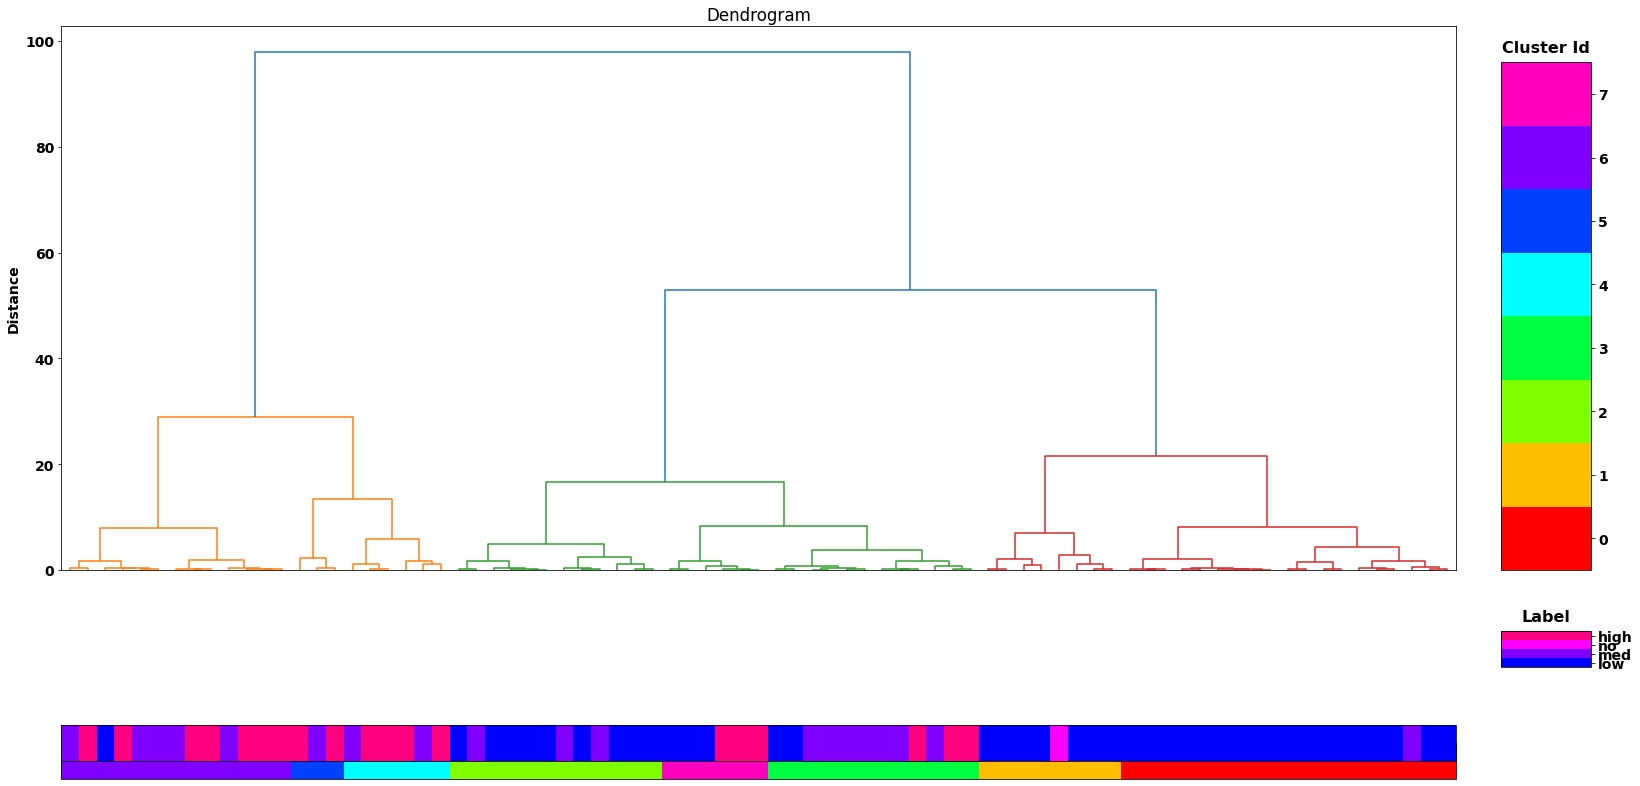

In [244]:
cluster_center(df=df, cols_to_cluster=cols_to_cluster, n_cluster=n_cluster, 
               leaf_label_col=leaf_label_col, response_col=response_col, remove_ticks=remove_ticks,
                   response_color_cols=response_color_cols, drop_duplicates=drop_duplicates, 
                   add_noise=add_noise, linkage_method=linkage_method, linkage_metric=linkage_metric,
                   weights=weights, qtl=qtl, cluster_color_method=cluster_color_method, color_dict=color_dict,
                    save=save, save_dir=save_dir, plot_dendogram = plot_dendogram)

In [245]:
back_df_with_clusters = pd.read_csv(f'../data/data_v1/labelme/type_is_back/cluster_data.csv')
belly_df_with_clusters = pd.read_csv(f'../data/data_v1/labelme/type_is_belly/cluster_data.csv')

In [253]:
def odd(Y):
    try:
        if Y[1] > 0:
            odd = Y[0]/Y[1]
        else:
            odd = 0
    except:
        odd = 0
    return odd

def contigency_table(df_row, row_cols, df_column, column_cols, row_name, column_name, save=False, save_dir=None, file_type='csv'):
 
    cross_tab = pd.crosstab(df_row[row_cols], df_column[column_cols], margins=True, margins_name="Total")
    
    y_categories = cross_tab.columns[:-1]
    i = 1
    for category in cross_tab.index: 
        row_counts = cross_tab.loc[category, y_categories].values
        if i <= 2:
            print(f"Pred column: {row_cols}, Category: {category}, Row Count:{row_counts}")

        cross_tab.loc[category, "Odd"] = odd(row_counts)
        i +=1
    cross_tab_prop = cross_tab.copy(deep=True)
    
    grand_total = cross_tab.loc["Total", "Total"]
    cross_tab_prop[y_categories] = cross_tab[y_categories] / grand_total
    cross_tab_prop["Total"] = cross_tab["Total"] / grand_total

    # Assign multi-index
    multi_index = pd.MultiIndex.from_product([[row_cols], cross_tab.index], names=[row_name, column_name])
    cross_tab.index = multi_index
    cross_tab_prop.index = multi_index
    
    if save:
        if save_dir is None:
            count_file_name = f'contigency_table.{file_type}'
            prop_file_name = f'contigency_table_prop.{file_type}'
        else:
            os.makedirs(save_dir, exist_ok=True)
            count_file_name = os.path.join(save_dir, f'contigency_table.{file_type}')
            prop_file_name = os.path.join(save_dir, f'contigency_table_prop.{file_type}')

        if file_type == 'csv':
            cross_tab.to_csv(count_file_name)
            cross_tab_prop.to_csv(prop_file_name)
        else:
            raise ValueError("file_type must be either 'csv'")




In [254]:
df_row = back_df_with_clusters
row_cols = 'Clusters'
row_name = 'Back'
df_column = belly_df_with_clusters
column_cols = 'Clusters'
column_name = 'Belly'
save=True
save_dir=f'../data/data_v1/labelme/contigency_tables'
file_type='csv'
contigency_table(df_row, row_cols, df_column, column_cols, row_name=row_name, column_name=column_name, save=save, save_dir=save_dir, file_type=file_type)

Pred column: Clusters, Category: 0, Row Count:[2 0 0 0 0 0 0 0]
Pred column: Clusters, Category: 1, Row Count:[2. 4. 2. 1. 0. 0. 2. 0.]
